# Solve water droplet shapes using Python

**Date:** 1.2.2017

**Author:** Juuso Korhonen

The shape of water droplets on surface is governed by two competing interactions, namely gravity and surface tension. For large bodies of water, gravity governs the behavior and water forms puddles, lakes, and oceans. For small quantities of water, surface tension is the deciding interaction and droplets assume spherical shapes. 

**The following is an excerpt from my doctoral dissertation, which can be found from:** http://urn.fi/URN:ISBN:978-952-60-5260-1

![The geometry used in deriving the Young–Laplace -shape of a drop in the axisym- metric case.](img/drop_solver_fig_2_10.png)

Axisymmetric drop-shape analysis (ADSA) yields the most accurate and physically relevant results in sessile drop contact angle analysis.76,77 Consider a
system shown in Figure 2.10, where a drop lies on a surface. Young–Laplace equation states that the pressure difference across the water–air interface is
equal to $\Delta p = \gamma C$, where $C = \frac{1}{R_1} + \frac{1}{R_2}$ is the curvature of the surface. The $z$-axis is drawn downwards from the top of the drop and the $x$-axis represents the distance from the $z$-axis. The radii of curvature are rewritten with the help of geometrical considerations (see Figure 2.10b,c):

$$
ds = R_1 d\phi \equiv \frac{1}{R_1} = \frac{d\phi}{ds} \\
\sin \phi = \frac{x}{R_2} \equiv \frac{1}{R_2} = \frac{\sin \phi}{x}
$$

Hydrostatic pressure, $\Delta \rho g z$, acts on the drop, yet at the top it is zero, which leads to:

$$
\frac{1}{R_1} = \frac{1}{R_2} = \frac{1}{R_0} = b \\
\gamma \left( \frac{1}{R_1} + \frac{1}{R_2} \right) = \gamma \frac{2}{R_0} = 2 b \gamma = \Delta p_0
$$

At heights, $z > 0$, hydrostatic pressure is taken into account by writing:

$$
\Delta p (z) = \Delta p_0 + \Delta p_g (z) = 2b\gamma + \Delta \rho g z \\
\Rightarrow \frac{d\phi}{ds} = 2b + \kappa z - \frac{\sin \phi}{x}
$$

where the capillary length, $\kappa^{-1} = \lambda_c = \frac{\gamma}{\Delta \rho g}$ , was employed. A set of differential equations can now be written with the help of geometrical identities:

$$
\frac{d\phi}{ds} = 2b + \kappa z - \frac{\sin \phi}{x} \\
\frac{dx}{ds} = \cos \phi \\
\frac{dz}{ds} = \sin \phi
$$

Using $s$ as the free parameter, at the top of the drop, $s = 0$, which leads to $x(0) = z(0) = 0$ and $d\phi = b$. No general solution exists for this set, yet numerical integration readily yields the axisymmetric drop profile.

**The numerical integration of the differential equations is demostrated below using Python with Scipy library.**


### MIT License

Copyright 2017 Juuso Korhonen

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
from __future__ import division, absolute_import, print_function, unicode_literals

In [2]:
import numpy as np
import scipy
from scipy.integrate import odeint, trapz, cumtrapz
from scipy.optimize import minimize, minimize_scalar, least_squares
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

## Define physical constants for water

Constants are defined here in SI units. Note, however, that surface tension is typically written in terms of $mN/m$ or $mJ/m^2$.

In [3]:
# Define some constants
gamma = 72.8e-3 # N/m
rho = 1000.0 # kg/m3
g = 9.81 # m/s2

## Young-Laplace equation

The following function returns the derivative of $\vec{y} = [\phi, x, z]^T$, which is defined by the set of differential equations given in the introduction.

In [4]:
def yl(y, s, b, c=rho*g/gamma):
    """
    Calculates the derivate if the Young-Laplace equation
    @param y   - a vector (phi, x, z)
    @param s   - integration parameter (unused)
    @param b   - 1/R0 (curvature at top of drop)
    @param c   - drho g / gamma (capillary constant) 
    @returns dx/ds
    """
    (phi, x, z) = y
    # Handle special case of x=0 and phi=0
    if x == 0 and phi == 0:
        dphi_ds = 2*b + c*z
    else:
        dphi_ds = 2*b + c*z - np.sin(phi)/x
    dx_ds = np.cos(phi)
    dz_ds = np.sin(phi)
    return [dphi_ds, dx_ds, dz_ds]

## Droplet volume

In the axisymmetric case, we can just integrate the drop shape to get the drop volume: $V = \int \pi x^2 dz$. Here, the trapezoid function from the SciPy.integrate module is used for integration.

In [5]:
def calc_volume(y):
    """Calculates drop volume from shape matrix."""
    return trapz(np.pi*y[:,1]**2, y[:,2])

## Guess radius of curvature from volume

Usually, it is not the radius of curvature at the top of droplet that is known *a priori*, but the volume of the desired droplet. The following function makes a rough guess for $R_0$ using a spherical cap approximation. The approximation is valid for small droplets, but fails for larger ones where gravity takes over.

In [72]:
def drop_shape_estimate(R, ca, c=rho*g/gamma):
    """Returns approximate height, R0 (given), volume, path length, and ca as a tuple."""
    x = np.cos(np.deg2rad(ca))
    # Spherical cap approximation
    vol = np.pi/3.0*R*(x**3-3*x+2)
    # Height from spherical cap approximation
    h = R*(1-x)
    # Path length from spherical cap approximation
    l_c = R*np.deg2rad(ca)
    
    return (h, R, vol, l_c, ca)

In [7]:
def drop_shape_estimate_for_volume(vol, ca, c=rho*g/gamma):
    """Returns approximate height, R0, volume (given), path length, and ca as a tuple."""
    x = np.cos(np.deg2rad(ca))
    # Spherical cap approximation with static R != R(z)
    R = np.power(3 * vol / (np.pi*(x**3-3*x+2)), 1/3)
    # Height of drop from spherical cap approximation
    h = R*(1-x)
    # Path length from spherical cap approximation
    l_c = R*np.deg2rad(ca)
    
    return (h, R, vol, l_c, ca)

## Droplet shape calculation

Droplet shape can be solved by starting from $\vec{y} = [0, 0, 0]^T$ and solving the differential equations in each step.

The solver requires the radius of curvature at the top of droplet, $R_0$, as the defining parameter and solves the for all values of the parameter $s$, which is estimated on the fly by using simple heuristics: for small droplets assume a spherical shape, and for larger droplets a puddle shape. The heuristics might need fine tuning if the algorithm fails to produce adequate accuracy.

Contact angle, $\theta$ (CA), is used to remove all data points that occur after $\phi > \theta$. Note, that this process is done only after solving for all $s$. 

In [32]:
def drop_shape(R0, ca, s=None, volume=None):
    """Return the drop shape for given R0 and ca."""
    if s is None:
        (h_R, R0, vol_est, lc_R, ca) = drop_shape_estimate(R0, ca)
        if volume is not None:
            # Calculate another estimate
            (h_vol, R0_est, volume, lc_vol, ca) = drop_shape_estimate_for_volume(volume, ca)
        else:
            lc_vol = lc_R
        s = np.linspace(0, max(lc_R, lc_vol), 100)
    y = odeint(yl, [0.0, 0.0, 0.0], s, args=(1/R0,))

    # Find stop condition
    found_end = False
    for imax, yval in enumerate(y):
        if yval[0] >= np.deg2rad(ca):
            found_end = True
            break

    if found_end:
        # Remove excess points
        y = y[:imax]
        # Move points to baseline
        y = y - [0, 0, max(y[:,2])]
    else:
        #s = np.linspace(0, max(s), 100)
        #return drop_shape(R0, ca, s)
        raise RuntimeError(u"Stop condition not found. Perhaps increase s_max? Maximum theta={}, while expecting {}"
                           .format(np.rad2deg(y[-1][0]), ca))
        
    return y

## Calculate drop shape from given volume

Droplet volume can be calculated when $R_0$ is given. However, if we want to calculate a drop shape for a given drop volume, we have to use an iterative process. `fmin` is a function that calculates squared error for given volume and desired volume. By iteratively mimimizing this function, we can find the correct $R_0$ for the desired volume.

In [9]:
def fmin(V, volume):
    """Minimization function."""
    return (volume - V)**2/V

In [10]:
def drop_shape_for_volume(volume, ca):
    """Calculates the drop shape for given volume and ca."""
    # Make a guess for the radius of curvature
    (h, R0, volume, l_c, ca) = drop_shape_estimate_for_volume(volume, ca)
    
    # Minimize error
    res = minimize(lambda x: fmin(calc_volume(drop_shape(x, ca, volume=volume)), volume), R0, 
                   method='nelder-mead', options={'xtol': 1e-9})
    
    # Calculate resulting shape
    R0 = res.x[0]
    y = drop_shape(R0, ca)
    
    #true_volume = calc_volume(y)
    #print("{:.2f} uL --> {:.2f} uL ({:.2f})".format(1e9*volume, 1e9*true_volume, 1e9*fmin(true_volume, volume)))
    
    return y

## Plotting function

The following plotting function is an accessory, that plots a standard chart for the provided drop shape.

In [25]:
def plot_drop(y, color='k', label=None, annotate=True, ax=None, autoscale=True):
    """Plots the given drop shape."""
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    x_data = list(-y[:,1][::-1]) + list(y[:,1])
    y_data = list(-y[:,2][::-1]) + list(-y[:,2])
    #ax.plot(x_data, y_data, ls='-', color=color, marker='o', mfc=mfc, mec=mec)
    ax.plot(x_data, y_data, ls='-', marker='o', color=color, mec=color, mfc='w', mew=1.0, label=label)
    ax.axhline(0, ls='--', color='k')
    if autoscale:
        ax.set_ylim(min(y_data), 1.1*max(y_data))
    ax.set_aspect('equal')
    ax.set_xlabel("mm")
    ax.set_xticklabels(1000*ax.get_xticks())
    ax.set_ylabel("mm")
    ax.set_yticklabels(1000*ax.get_yticks())
    volume = calc_volume(y)
    if annotate:
        ax.text(0.5, 0.5, u"Contact angle: {:.4}\nVolume: {:.4} uL".format(np.rad2deg(y[-1,0]), volume*1e9), 
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes)

## Example plots

### Example 1

Plot a single drop with given $R0$ and $\theta$. The contact angle drawn in the graph is calculated from the resulting data and thus does not exactly match the provided value. This mismatch could be used to determine, whether the $s$ accuracy should be increased.

Contact angle: 150.0°
Volume: 368.9 uL


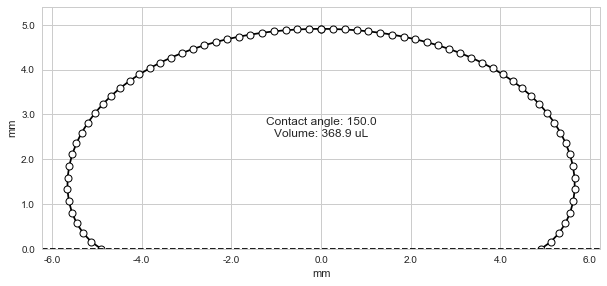

In [27]:
R0 = 10.0e-3 # 10 mm
ca = 150.0

y = drop_shape(R0, ca)
vol = calc_volume(y)
plot_drop(y, annotate=True)

print(u"Contact angle: {:.4}°\nVolume: {:.4} uL".format(np.rad2deg(y[-1,0]), vol*1e9))

### Example 2

Plot different contact angles for given $R0$.

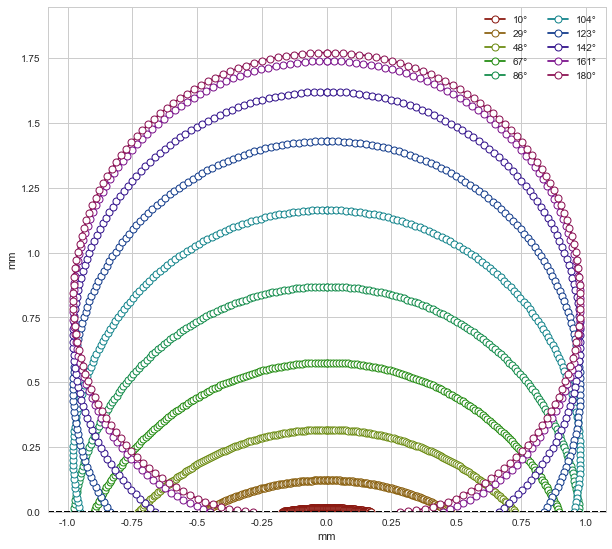

In [33]:
R0 = 1.0e-3 # 1 mm
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

num_graphs = 10
min_ca = 10
max_ca = 180

# Color palette
pal = sns.hls_palette(num_graphs, l=.3, s=.8)

for i, ca in enumerate(np.linspace(min_ca, max_ca, num_graphs)):
    y = drop_shape(R0, ca)
    plot_drop(y, ax=ax, color=pal[i], annotate=False, label=u"{:.0f}°".format(ca))

# Add legend to axis
leg = ax.legend(loc='best', ncol=2)

### Example 3

Plot different drop shapes for varying $R0$ and given contact angle.

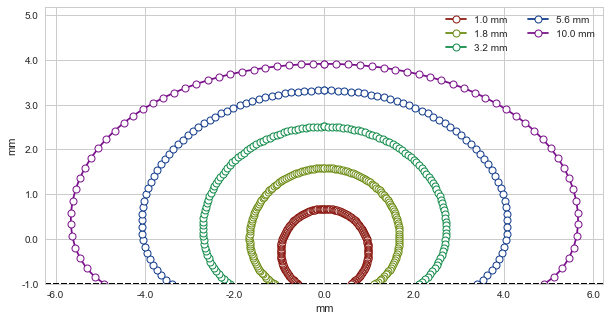

In [34]:
ca = 150.0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

num_graphs = 5
min_log_R0 = -3
max_log_R0 = -2

# Color palette
pal = sns.hls_palette(num_graphs, l=.3, s=.8)

for i, R0 in enumerate(np.logspace(min_log_R0, max_log_R0, num_graphs)):
    y = drop_shape(R0, ca)
    plot_drop(y, ax=ax, color=pal[i], annotate=False, label="{:.1f} mm".format(1000*R0), autoscale=False)

# Tweak limits
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1]*1.2)
    
# Add legend to axis
leg = ax.legend(loc='best', ncol=2)

### Example 4

Plot different shapes for a given volume by guessing $R_0$ using the spherical cap approximation.

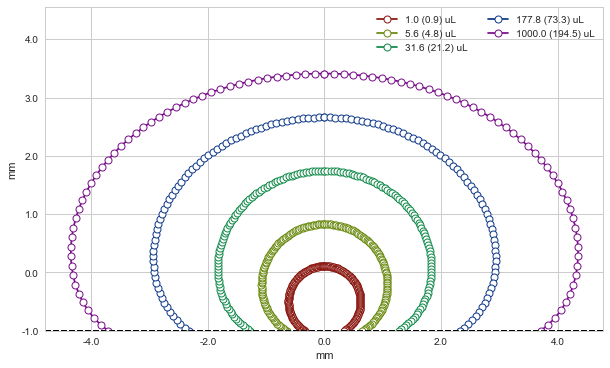

In [35]:
ca = 150.0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

num_graphs = 5
min_log_volume = -9
max_log_volume = -6

# Color palette
pal = sns.hls_palette(num_graphs, l=.3, s=.8)

for i, volume in enumerate(np.logspace(min_log_volume, max_log_volume, num_graphs)):
    (h, R0, volume, lc, ca) = drop_shape_estimate_for_volume(volume, ca)
    y = drop_shape(R0, ca)
    real_volume = calc_volume(y)
    plot_drop(y, ax=ax, color=pal[i], annotate=False, label=u"{:.1f} ({:.1f}) uL".format(1e9*volume, 1e9*real_volume), autoscale=False)

# Tweak limits
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1]*1.2)
    
# Add legend to axis
leg = ax.legend(loc='best', ncol=2)

### Example 5

Plot a droplet shape for given contact angle and (true) target volume.

Solving for volume 10.0 uL, and ca 150.0°
Volume 10.0 uL


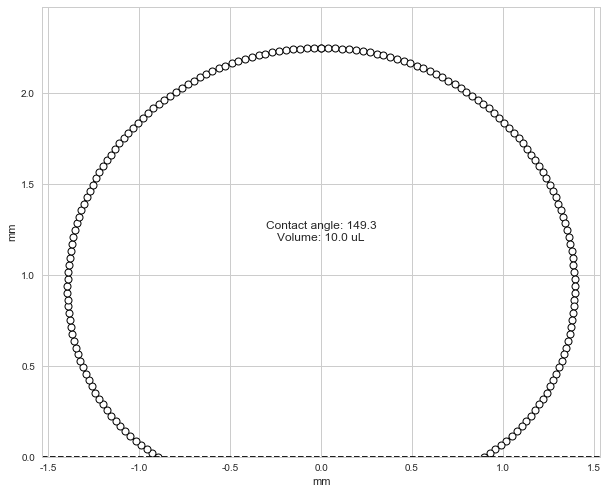

In [36]:
volume = 10.0e-9
ca = 150.0

print("Solving for volume {:.3} uL, and ca {}°".format(volume*1e9, ca))

y = drop_shape_for_volume(volume, ca)
true_volume = calc_volume(y)
print("Volume {:.3} uL".format(true_volume*1e9))

# Plot data
plot_drop(y)

### Example 6

Plot different drop shapes for a list of given volumes.

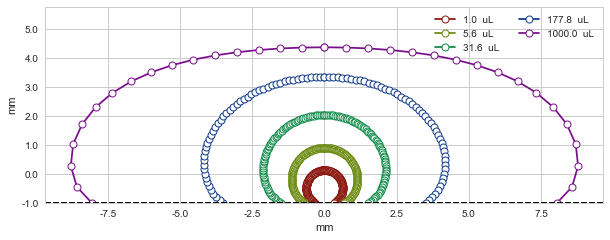

In [37]:
ca = 150.0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

num_graphs = 5
min_log_volume = -9
max_log_volume = -6

# Color palette
pal = sns.hls_palette(num_graphs, l=.3, s=.8)

for i, volume in enumerate(np.logspace(min_log_volume, max_log_volume, num_graphs)):
    y = drop_shape_for_volume(volume, ca)
    plot_drop(y, ax=ax, color=pal[i], annotate=False, label="{:.1f}  uL".format(1e9*volume), autoscale=False)
    
# Tweak limits
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1]*1.2)
    
# Add legend to axis
leg = ax.legend(loc='best', ncol=2)

### Example 7

Evaluate model with different CA's and volumes.

Plot the error in volume determination as a function of $\theta$ and $V$. 

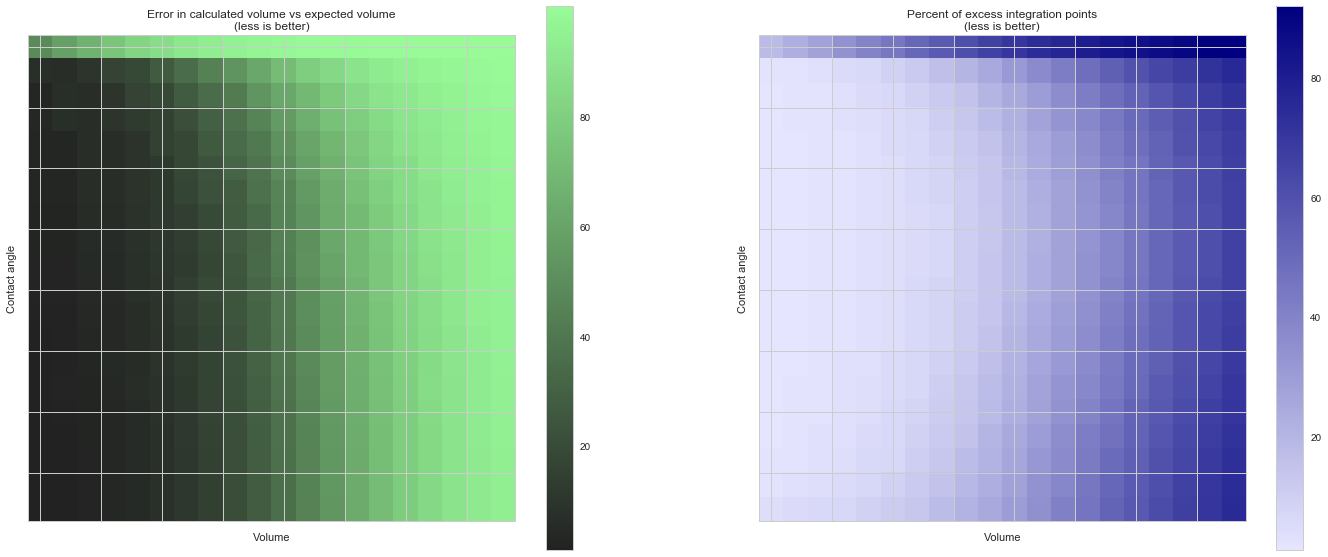

In [70]:
cas = np.linspace(0.1, 179.9, 20)
vols = np.logspace(-10, -5, 20)

res_vols = np.zeros((len(cas), len(vols)))
res_lens = np.zeros((len(cas), len(vols)))

if True: # <-- Set to false to disable updating res_vols (for testing purposes, that is)
    for i, ca in enumerate(cas):
        for j, vol in enumerate(vols):
            try:
                (h, R0, vol, lc, ca) = drop_shape_estimate_for_volume(vol, ca)
                y = drop_shape(R0, ca)
            except RuntimeError as e:
                print("Failed to converge for vol={} uL, ca={}°, R0={} mm".format(vol*1e9, ca, R0*1e3))
                res_vols[i,j] = np.Inf
                res_lens[i,j] = np.NaN
            else:
                true_vol = calc_volume(y)
                res_vols[i,j] = (true_vol-vol)/vol
                res_lens[i,j] = (100.0-len(y))/100.0

# Now, plot the result
fig = plt.figure(figsize=(24,10))
ax = fig.add_subplot(121)
cmap = sns.dark_palette("palegreen", as_cmap=True)
img = ax.imshow(100.0*np.abs(res_vols), interpolation='nearest', cmap=cmap)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(img, cmap=cmap, ax=ax)
ax.set_xlabel("Volume")
ax.set_ylabel("Contact angle")
ax.set_title("Error in calculated volume vs expected volume\n(less is better)")

ax2 = fig.add_subplot(122)
cmap2 = sns.light_palette("navy", as_cmap=True)
img2 = ax2.imshow(100.0*np.abs(res_lens), interpolation='nearest', cmap=cmap2)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.colorbar(img2, cmap=cmap2, ax=ax2)
ax2.set_xlabel("Volume")
ax2.set_ylabel("Contact angle")
ax2.set_title("Percent of excess integration points\n(less is better)")

### Example 8

Evaluate calculation of with iterative optimization-based model.

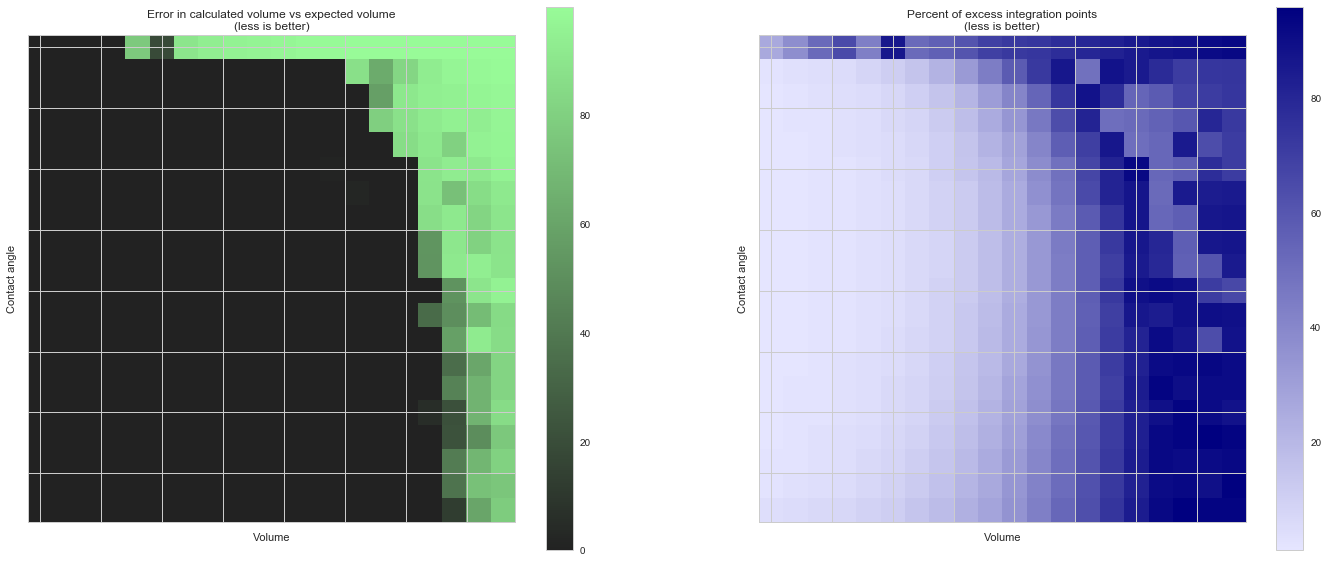

In [71]:
cas = np.linspace(0.1, 179.9, 20)
vols = np.logspace(-10, -5, 20)

res_vols_2 = np.zeros((len(cas), len(vols)))
res_lens_2 = np.zeros((len(cas), len(vols)))

if True: # <-- Set to false to disable updating res_vols (for testing purposes, that is)
    for i, ca in enumerate(cas):
        for j, vol in enumerate(vols):
            try:
                y = drop_shape_for_volume(vol, ca)
            except RuntimeError as e:
                print("Failed to converge for vol={} uL, ca={}°, R0={} mm".format(vol*1e9, ca, R0*1e3))
                res_vols_2[i,j] = np.Inf
                res_lens_2[i,j] = np.NaN
            else:
                true_vol = calc_volume(y)
                res_vols_2[i,j] = (true_vol-vol)/vol
                res_lens_2[i,j] = (100.0-len(y))/100.0
                
# Now, plot the result
fig = plt.figure(figsize=(24,10))
ax = fig.add_subplot(121)
cmap = sns.dark_palette("palegreen", as_cmap=True)
img = ax.imshow(100.0*np.abs(res_vols_2), interpolation='nearest', cmap=cmap)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(img, cmap=cmap, ax=ax)
ax.set_xlabel("Volume")
ax.set_ylabel("Contact angle")
ax.set_title("Error in calculated volume vs expected volume\n(less is better)")

ax2 = fig.add_subplot(122)
cmap2 = sns.light_palette("navy", as_cmap=True)
img2 = ax2.imshow(100.0*np.abs(res_lens_2), interpolation='nearest', cmap=cmap2)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.colorbar(img2, cmap=cmap2, ax=ax2)
ax2.set_xlabel("Volume")
ax2.set_ylabel("Contact angle")
ax2.set_title("Percent of excess integration points\n(less is better)")